In this lab we look at various unsupervised dimensionality reduction methods. By reducing the dimensionality to two or three dimensions only, we can visualise the data by e.g. scatter plots. Moreover, when we deal with labeled data, we may hope that in the low-dimensional space the classes are well-separated, that is, the transformed low-dimensional data form clusters which correspond to the different classes.

As in Lab 1, we use the landsat satellite dataset which is 36-dimensional and comprises 6 classes.

In [61]:
# to get rid of possible future warnings cluttering the notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import required packages 
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import random
from sklearn import manifold
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# Preprocessing and initial visualisations

## Question 1: loading the data

Load the `landsat_train.csv` dataset into a `pandas` DataFrame called  `landsat_train` and display the shape of the DataFrame. Moreover, load the label names stored in `landsat_classes.csv` into a single dictionary called `landsat_labels_dict` and print the names of the classes.

In [56]:
# Read in data
landsat_train = pd.read_csv("../datasets/landsat/landsat_train.csv")
# 0 index labels to match Python dict convention
landsat_train['label'] = landsat_train['label'].map(lambda label: label - 1) 
landsat_train.shape

(4435, 37)

In [57]:
landsat_train

,pixel_1_1,pixel_1_2,pixel_1_3,pixel_1_4,pixel_2_1,pixel_2_2,pixel_2_3,pixel_2_4,pixel_3_1,pixel_3_2,...,pixel_7_4,pixel_8_1,pixel_8_2,pixel_8_3,pixel_8_4,pixel_9_1,pixel_9_2,pixel_9_3,pixel_9_4,label
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,2
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,2
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,2
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,2
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,56,64,108,96,64,71,108,96,68,75,...,92,66,83,108,96,66,87,104,89,4
4431,64,71,108,96,68,75,108,96,71,87,...,96,66,87,104,89,63,87,104,89,4
4432,68,75,108,96,71,87,108,88,71,91,...,89,63,87,104,89,70,100,104,85,3
4433,71,87,108,88,71,91,100,81,76,95,...,89,70,100,104,85,70,91,104,85,3


In [58]:
# Manipulate landsat_classes csv into Python dict
landsat_classes = pd.read_csv("../datasets/landsat/landsat_classes.csv")
landsat_classes = landsat_classes.to_dict()
landsat_classes.pop("Unnamed: 0")
landsat_labels_dict = landsat_classes["Class"]
landsat_labels_dict

{0: 'red soil',
 1: 'cotton crop',
 2: 'grey soil',
 3: 'damp grey soil',
 4: 'soil with vegetation stubble',
 5: 'mixture class (all types present)',
 6: 'very damp grey soil'}

Now we want to replace the label numbers in the `landsat_train` DataFrame with the corresponding class names. We can achieve that by using the `pandas` function `replace()`. The `inplace` argument determines whether the method alters the object it is called upon and returns nothing, or returns a new object (when `inplace` is set to `False`).  

Execute the cell below which performs this replacement. The second line is used to show a random sample of 5 entries of the DataFrame for us to inspect the outcome of this transformation.

In [59]:
# Replace label numbers with their names
landsat_train.replace({'label' : landsat_labels_dict}, inplace=True)
landsat_train.sample(n=5, random_state=10)

,pixel_1_1,pixel_1_2,pixel_1_3,pixel_1_4,pixel_2_1,pixel_2_2,pixel_2_3,pixel_2_4,pixel_3_1,pixel_3_2,...,pixel_7_4,pixel_8_1,pixel_8_2,pixel_8_3,pixel_8_4,pixel_9_1,pixel_9_2,pixel_9_3,pixel_9_4,label
2893,67,81,86,64,67,81,82,64,67,77,...,65,68,77,86,65,72,81,86,68,very damp grey soil
43,80,94,102,83,76,89,98,79,68,77,...,83,79,91,104,79,75,79,96,79,soil with vegetation stubble
942,46,32,133,136,46,32,133,136,46,32,...,140,44,34,129,140,44,34,124,136,cotton crop
349,89,102,110,87,93,106,114,90,93,111,...,88,88,107,118,88,88,107,113,88,grey soil
4204,49,77,93,75,46,66,86,72,49,70,...,76,50,73,90,76,50,73,94,79,red soil


Finally, we would like to store the features and the labels in two different `numpy` arrays. For that, will use the following two methods:
* the `pandas` `drop()` method to remove columns or rows from a DataFrame ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)). We will use it to drop the `label` column.
* the `to_numpy` method to transform a DataFrame into float64 numpy array ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html)).


In [60]:
X = landsat_train.drop('label', axis=1).to_numpy(dtype='float64') # Input features
y = landsat_train['label'].to_numpy()  # Labels
print('Dimensionality of X: {}\nDimensionality of y: {}'.format(X.shape, y.shape))

print(type(X[0,0]))

Dimensionality of X: (4435, 36)
Dimensionality of y: (4435,)
<class 'numpy.float64'>


## Question 2: feature standardisation

Feature standardisation is a pre-processing technique that is often used to transform data so that the variables/features are standardised to have the same location and scale. For many algorithms, this is a very important step for training models (both in the context of regression and classification). Read about feature standardisation in the lecture notes and e.g. [here](http://scikit-learn.org/stable/modules/preprocessing.html). 

Scikit-learn offers an [implementation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Machine learning methods in scikit-learn are implemented as `estimators` with a uniform API (see the [documentation](https://scikit-learn.org/stable/developers/develop.html), optional reading). All estimators implement a `fit` method to learn from data. Classes for supervised learning further provide the `predict` method which predicts outputs (labels) from inputs (e.g. the data matrix `X` above). Classes for unsupervised learning provide the `transform` method to transform the original data into an alternative representation. Sometimes, fitting and transforming can be done more efficiently together. In this case, the classes provide the `fit_transform` method.

Create a `StandardScaler` and use it to fit and transform `X`. Save the results in a new array `X_sc`. Print the means and standard deviations (of the first 4 columns/features) of the original data `X` and the standardised data `X_sc` as a sanity check. 

**For the rest of this lab you should use the standardised data (i.e. `X_sc`), unless you are explicitly asked to do otherwise.**


In [100]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

print("X_sc means and sds...\n")
print(np.mean(X_sc[:,:4], axis=0)) 
print(np.std(X_sc[:,:4], axis=0))

print("\nX means and sds...\n")
print(np.mean(X[:,:4], axis=0)) 
print(np.std(X[:,:4], axis=0))

X_sc means and sds...

[ 4.35778183e-16  1.53804065e-16 -1.05740294e-16 -1.92255081e-16]
[1. 1. 1. 1.]

X means and sds...

[69.47395716 83.85524239 99.32288613 82.55558061]
[13.64809572 22.72251646 16.67028645 18.69334235]


## Question 3: visualisations
In order to get a first idea about the data, we can use basic explorations and visualisations as those in lab 1. Below we will be using various dimensionality reduction methods to obtain (hopefully!) more informative visualisations in 2D. For your convenience, we provide the following function `scatter_2d_label()` to create a 2D scatter plot that also annotates the corresponding classes appropriately. Execute the following cell and make sure you understand what this function does.

In [149]:
def scatter_2d_label(X_2d, y, ax=None, s=2, alpha=0.5, lw=2, add_legend=True):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    
    targets = np.unique(y)  # extract unique labels
    colors = sns.color_palette(n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)
    
    # add legend
    if add_legend:
        ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax

The following cell selects two columns of `X_sc` (i.e. features in the high-dimensional space) and uses the `scatter_2d_label()` function provided above to visualise the 2D scatter plots. Feel free to experiment with other dimensions too.

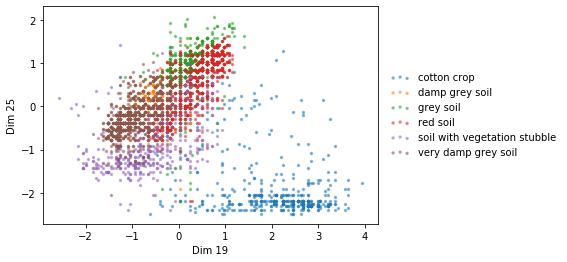

In [107]:
dim_1 = 19 # First dimension
dim_2 = 25 # Second dimension

fig, ax = plt.subplots()
scatter_2d_label(X_sc[:, [dim_1,dim_2]], y, ax=ax)
ax.set(xlabel='Dim {}'.format(dim_1), ylabel= 'Dim {}'.format(dim_2));

Plotting dimension 19 versus 25 shows that e.g. cotton crop takes on rather different values than the other classes even after standardisation, and hence should be easy to separate in a classification problem.

An alternative to scatter plots are two-dimensional kernel density estimates. The function `kde_2d_label()` below produces a two-dimensional kernel density estimates separately for each class. Make sure to understand what each line does. 

Below we discuss in more detail the choice of the colour palette, i.e. the commands `sns.color_palette` and `sns.dark_palette` as they are used in many more contexts than kernel density estimation. If you would like to know more about the `mlines.Line2D([],[], ...)` command, see [here](https://matplotlib.org/3.3.3/tutorials/intermediate/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists) (optional reading).

In [108]:
def kde_2d_label(X_2d, y, ax=None):
    """Kernel density estimate in a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Data to plot
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on    
    """
    
    if ax is None:
        fig, ax = plt.subplots()
        
    targets = np.unique(y)
    palette_name = 'bright'
    colors = sns.color_palette(palette_name, n_colors=targets.size)
    lines = []
    for color, target in zip(colors, targets):
        sns.kdeplot(X_2d[y==target, 0], X_2d[y==target, 1], ax=ax, cmap=sns.dark_palette(color, as_cmap=True))
        lines.append(mlines.Line2D([], [], color=color, label=target))  # dummy line for the legend
    
    # add legend
    ax.legend(lines, targets, loc='center left', bbox_to_anchor=[1.01, 0.5], frameon=False) 
    

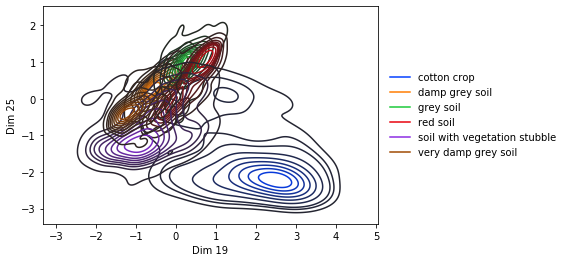

In [109]:
# the scatter plot from above becomes
kde_2d_label(X_sc[:, [dim_1,dim_2]], y)
ax = plt.gca()
ax.set(xlabel='Dim {}'.format(dim_1), ylabel= 'Dim {}'.format(dim_2));

With `sns.color_palette`, we can control the colours used to visualise the data. Have a quick look at its [documentation](https://seaborn.pydata.org/generated/seaborn.color_palette.html). The most important parameters are `palette` and `n_colors`, which specifies how many number of colours of the palette to use. The options for `palette` are a bit more complicated but it is worthwhile to understand the different kinds of palettes that are available. The explanations below are based on the seaborn tutorial ["Choosing color palettes"](https://seaborn.pydata.org/tutorial/color_palettes.html).

An important guiding principle in choosing palettes is to use different hues ("colors", e.g. red or blue) to represent categories that do not have any ordering (e.g. the class labels above) while using variations in luminance/lightness to represent quantities with a natural ordering (e.g. numbers). Saturation of a colour can be used make different hues look more distinct.

The available palettes can be classified into three categories:
- qualitative palettes: these are used for categorical data. An example is `tab10` (slightly more intense than the default palette) or `Set2`.
- sequential palettes: these are appropriate when data have a natural ordering and range from relatively low or uninteresting values to relatively high or interesting values (or vice versa). An example is `viridis`. Note that every continuous colormap has a reversed version, which has the suffix "_r", e.g. `viridis_r`.  
- diverging palettes: these are best suited for datasets where both the low and high values are of equal interest while the midpoint should be deemphasised. This can be used to visualise extreme events such as hot and cold temperatures. An example is `vlag`.

The default palette that you get with `palette=None` is of the qualitative type. Seaborn offers six variations of the default that have different levels of luminance and saturations. You can set them by choosing one of the following values for the `palette` parameter:  `deep`, `muted`, `pastel`, `bright`, `dark`, `colorblind`.  The tutorial has a [helpful figure](https://seaborn.pydata.org/tutorial/color_palettes.html#qualitative-color-palettes) that shows the resulting colormaps along the saturation and luminance "dimensions". [This page](https://gist.github.com/mwaskom/b35f6ebc2d4b340b4f64a4e28e778486) visualises how the different palettes appear for people with various color vision deficiencies. 

In the code above, we also use `sns.dark_palette(color, as_cmap=True)`. This, and its counterpart `light_palette` can be used to generate custom sequential palettes that start with either dark or light values and smoothly ramp up to the target specified as `color`. This allows us to visualise the values of the kernel density estimate with the same hue that we used to represent the category.

Finally, note that with `as_cmap` we control the type of the return value: RGB values (`as_cmap=False`) or matplotlib colormaps  (`as_cmap=True`).

Use the piece of code below to experiment with different colour palettes. You can use `plt.colormaps()` to get a (long) list of matplotlib colourmaps and/or have a look at its [documentation](https://matplotlib.org/api/pyplot_summary.html?highlight=colormaps#matplotlib.pyplot.colormaps). A further great resource for colour palettes is the [Color Brewer](https://colorbrewer2.org/). 

In [111]:
plt.colormaps()

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cividis',
 'cividis_r',
 'cool',
 'cool_r',
 'co

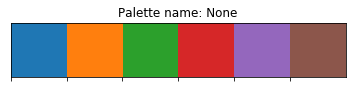

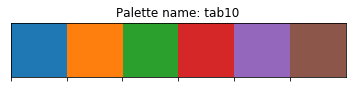

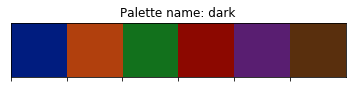

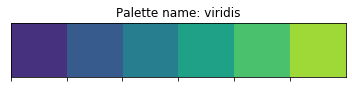

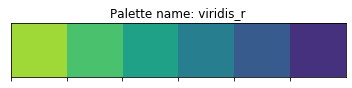

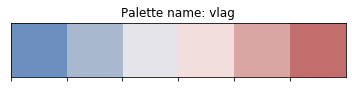

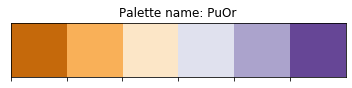

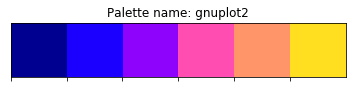

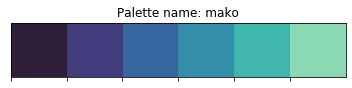

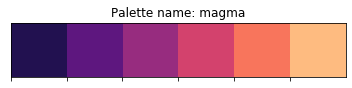

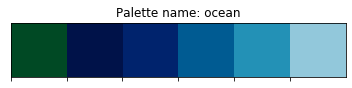

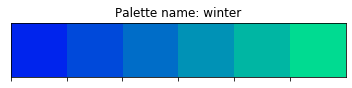

In [112]:
targets = np.unique(y)

# for example
palette_names = [None, 'tab10', 'dark', 'viridis', 'viridis_r', 'vlag', 'PuOr', 'gnuplot2',
                'mako', 'magma', 'ocean', 'winter']

for i, palette in enumerate(palette_names):
    colors = sns.color_palette(palette, n_colors=targets.size)
    sns.palplot(colors)
    plt.title('Palette name: ' + str(palette))

# Linear dimensionality reduction by PCA

In Lab 2, we implemented principal component analysis (PCA) from scratch and have seen how to [perform PCA with scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). We will use it here for (linear) dimensionality reduction. 

## Question 4: computing the PC scores
Use scikit-learn to compute the first two PC scores from the (standardised) input data and visualise the lower-dimensional representation with `scatter_2d_label` or `kde_2d_label`. Interpret the learned representation.

In [113]:
from sklearn.decomposition import PCA

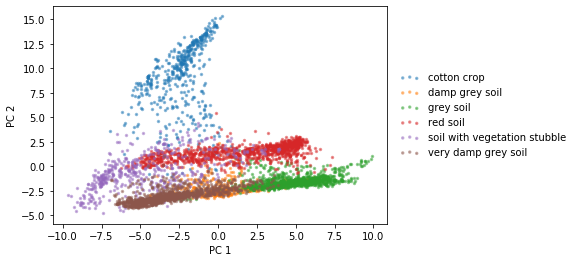

In [121]:
# no. of principle components
k = 2 

# grab PC scores
pca = PCA(n_components=k).fit(X_sc)
pc_scores = pca.transform(X_sc)

# visualise PC scores as scatter plot
fig, ax = plt.subplots()
scatter_2d_label(pc_scores, y, ax=ax)
ax.set(xlabel='PC 1', ylabel= 'PC 2');

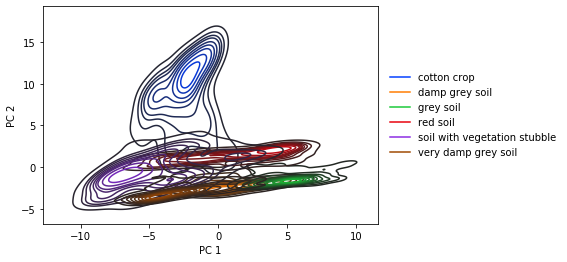

In [120]:
# visualise pc scores as kde
fig, ax = plt.subplots()
kde_2d_label(pc_scores, y, ax=ax)
ax.set(xlabel='PC 1', ylabel= 'PC 2');

# Dimensionality reduction by kernel PCA

In PCA, the lower dimensional representation is obtained by linear projections and this can severely limit the usefulness of the approach. Several versions of nonlinear PCA have been proposed in the hope of overcoming this problem. One such algorithm is kernel PCA (KPCA).

Kernel PCA uses the  "kernel trick" to create a nonlinear version of PCA in sample space by performing ordinary PCA in the augmented kernel space. Scikit-learn offers an implementation of KPCA that supports various kernels.  Familiarise yourself with the `KernelPCA` class  by reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA).

## Question 5: effect of the kernel

Apply kernel PCA to the standardised data `X_sc`. Set the `n_components` parameter to `2` and use default settings for other parameters. Experiment with different kernels. How do the results differ when different kernels are used?

In [133]:
from sklearn.decomposition import KernelPCA

# no. of principle components
k = 2 

# grab linear PC scores
kpca = KernelPCA(n_components=k, kernel='linear').fit(X_sc)
kpc_scores = kpca.transform(X_sc)

# grab poly PC scores
kpca_poly = KernelPCA(n_components=k, kernel='poly').fit(X_sc)
kpc_scores_poly = kpca_poly.transform(X_sc)

# grab rbf PC scores
kpca_rbf = KernelPCA(n_components=k, kernel='rbf').fit(X_sc)
kpc_scores_rbf = kpca_rbf.transform(X_sc)

# grab sigmoid PC scores
kpca_sigmoid = KernelPCA(n_components=k, kernel='sigmoid').fit(X_sc)
kpc_scores_sigmoid = kpca_sigmoid.transform(X_sc)

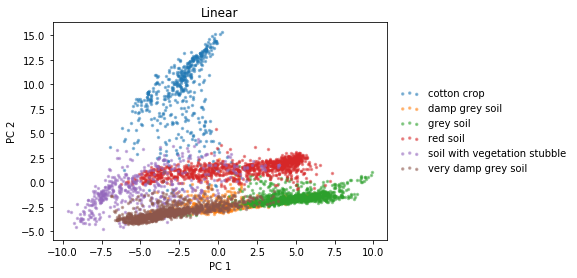

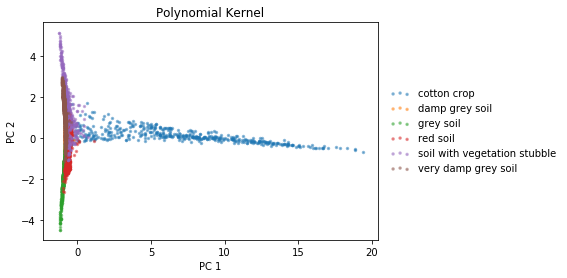

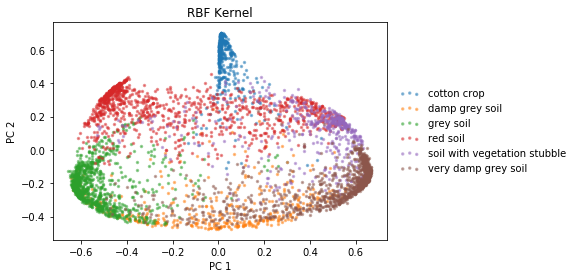

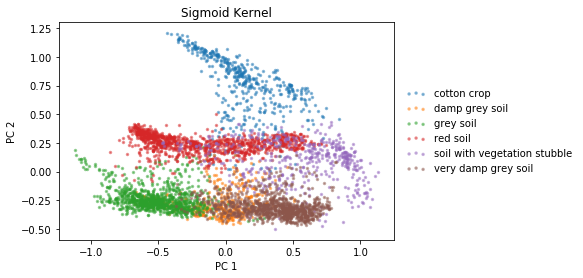

In [136]:
# Dataviz
# visualise PC scores as scatter plot
fig, ax = plt.subplots()
scatter_2d_label(kpc_scores, y, ax=ax)
ax.set(xlabel='PC 1', ylabel= 'PC 2', title='Linear');

fig, ax = plt.subplots()
scatter_2d_label(kpc_scores_poly, y, ax=ax)
ax.set(xlabel='PC 1', ylabel= 'PC 2', title='Polynomial Kernel');

fig, ax = plt.subplots()
scatter_2d_label(kpc_scores_rbf, y, ax=ax)
ax.set(xlabel='PC 1', ylabel= 'PC 2', title='RBF Kernel');

fig, ax = plt.subplots()
scatter_2d_label(kpc_scores_sigmoid, y, ax=ax)
ax.set(xlabel='PC 1', ylabel= 'PC 2', title='Sigmoid Kernel');

## Question 6: effect of standardisation

Apply kernel PCA with a RBF kernel to:
1. the raw data in `X`
2. the standardised data in `X_sc`. 

What do you observe? Can you explain the outcome?


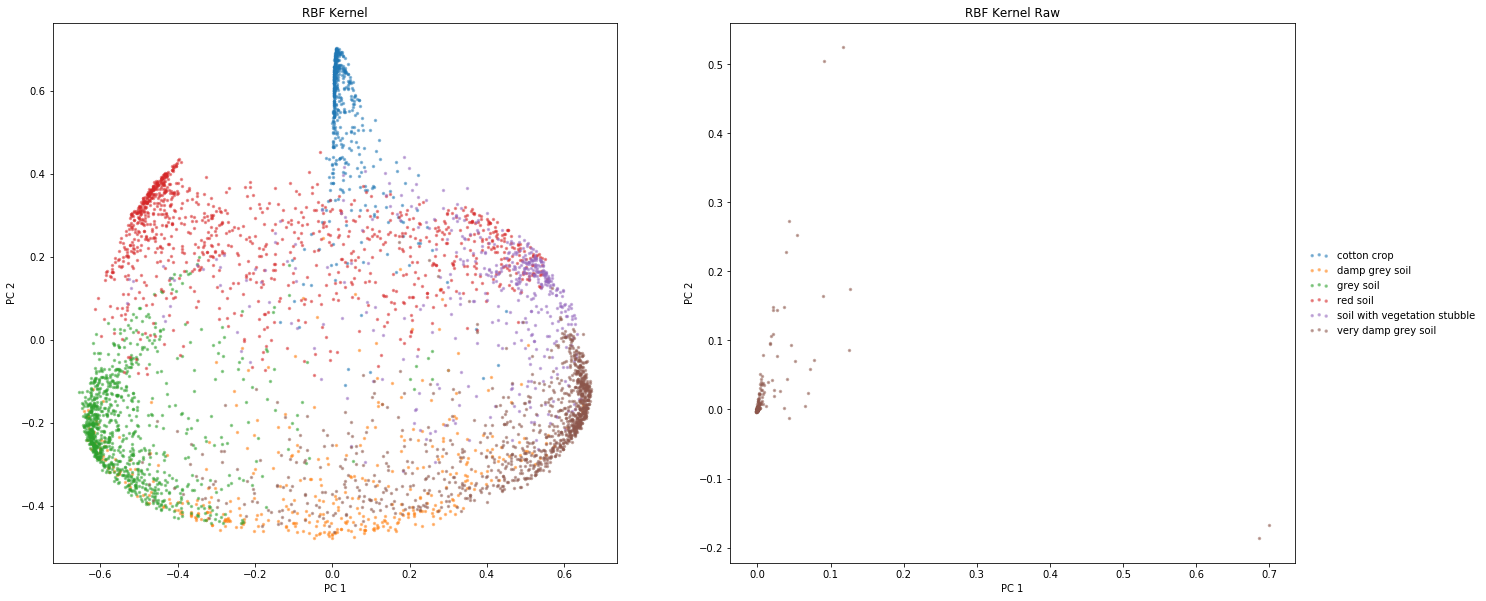

In [162]:
# grab linear PC scores
kpca_rbf_raw = KernelPCA(n_components=k, kernel='rbf').fit(X)
kpc_scores_raw = kpca_rbf_raw.transform(X)

fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=3, top=2, wspace=None, hspace=None)
scatter_2d_label(kpc_scores_rbf, y, ax=ax1, add_legend=False)
scatter_2d_label(kpc_scores_raw, y, ax=ax2)
ax1.set(xlabel='PC 1', ylabel='PC 2', title='RBF Kernel');
ax2.set(xlabel='PC 1', ylabel='PC 2', title='RBF Kernel Raw');

## Using the RBF Kernel on un-standardized data results in all PC scores to be squished together. This is because datapoints that are a large distance from eachother, as is the case for the un-standardized data, will results in the kernel being approx. 0.

# Multidimensional scaling (MDS)

Multidimensional scaling (MDS) refers to a collection of techniques for dimensionality reduction that operate on dissimilarities. The goal of MDS is to find a configuration of points in the plane, or more generally the Euclidean space, so that their distances well represent the original dissimilarities.

We look here into metric MDS (see Section 3.3.1 in the lecture notes). Scikit-learn offers an implementation.  Familiarise yourself with the class `MDS` by reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html). Note that with the default settings, Euclidean distances between the input data are used to obtain the pairwise dissimilarities $\delta_{ij}$ from the lecture notes. However, a major strength of MDS is that it operates on dissimilarities directly, and does not require access to data. If you want to operate on dissimilarities, you can to specify `dissimilarity='precomputed'` and feed the corresponding dissimilarity matrix to `fit` or `fit_transform`.

The attribute `stress_` corresponds to the minimal value of the loss function minimised in MDS (smaller values are better). Note: The stress does not seem to be correctly defined in the [user guide](https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling) (weights and the squaring are missing) but the loss used in the code is the same as the lecture notes (up to a factor 1/2 it seems).

## Question 7: MDS based on Euclidean distances
Compute a two-dimensional representation of the standardised data `X_sc` via scikit-learn using Euclidean distances between the original data points to define the dissimilarities. If the default settings result in too long compute times, you can e.g. reduce `max_iter` to `100` and/or `n_init` to `1`. You can parallelise computations using the `n_jobs` parameter.

Visualise the data by using the `scatter_2d_label()` function. What do you observe?

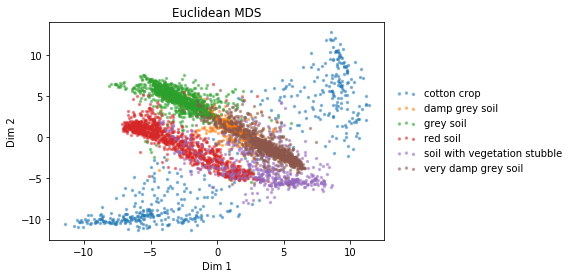

In [164]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity='euclidean', n_jobs=4)
mds_embedding = mds.fit_transform(X_sc)

fig, ax = plt.subplots()
scatter_2d_label(mds_embedding, y, ax=ax)
ax.set(xlabel='Dim 1', ylabel= 'Dim 2', title='Euclidean MDS');

## Question 8: MDS based on custom distances

We now apply MDS to a dissimilarity matrix directly. You can define your own dissimilarities to obtain the matrix, or you can also make use of distances that are already implemented in skit-learn or scipy via the `pairwise_distances` function (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html)).

Perform here MDS with the `braycurtis` or `canberra` dissimilarity available through `pairwise_distances` and interpret the results. The Bray-Curtis dissimilarity is used in ecology and the environmental sciences (see e.g. [here](http://www.econ.upf.edu/~michael/stanford/maeb5.pdf), optional reading). The Canberra dissimilarity is a weighted $L_1$ distance (see e.g. [here](https://en.wikipedia.org/wiki/Canberra_distance)). For their exact definitions, see [here](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html). 

/opt/anaconda3/envs/dme/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


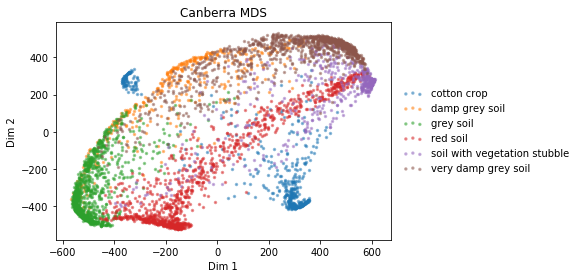

In [166]:
from sklearn.metrics.pairwise import pairwise_distances

canberra_dis = pairwise_distances(X_sc, metric='canberra')

mds_canberra = MDS(n_components=2, dissimilarity='precomputed', n_jobs=4)
mds_canberra_embedding = mds.fit_transform(canberra_dis)

fig, ax = plt.subplots()
scatter_2d_label(mds_canberra_embedding, y, ax=ax)
ax.set(xlabel='Dim 1', ylabel= 'Dim 2', title='Canberra MDS');

#  Isomap
MDS does not attempt to explicitly model the underlying data manifold. Isomap, on the other hand, addresses the dimensionality reduction problem by doing so. Suppose your data lie on a curve, but the curve is not a straight line. The key assumption made by Isomap is that the quantity of interest, when comparing two points, is the distance along the curve between the two points. 

In other words, Isomap performs MDS in the geodesic space of the nonlinear data manifold. The geodesic distances represent the shortest paths along the curved surface of the manifold measured as if the surface was flat. This can be approximated by a sequence of short steps between neighbouring sample points. Isomap then applies classical MDS to the geodesic rather than straight line distances to find a low-dimensional mapping that preserves these pairwise distances.

To summarise, Isomap uses three steps:
1.  Find the neighbours of each data point in high-dimensional data
2.  Compute the geodesic pairwise distances between all points
3.  Embed the data via classical MDS so as to preserve these distances.


Familiarise yourself with the Isomap class in scikit-learn by reading the [user guide](http://scikit-learn.org/stable/modules/manifold.html#isomap) and  [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html).


## Question 9: influence of the neighbourhood

Project the standardised data into a 2D space via the Isomap algorithm. Explore the role of the `n_neighbors` parameter which defines how many neighbours are used in step 1 above. You can start by trying the following values, but feel free to experiment further: [2, 3, 5, 10]. How sensitive is the algorithm to the choice of `n_neighbors`?

Use default settings for other parameters.

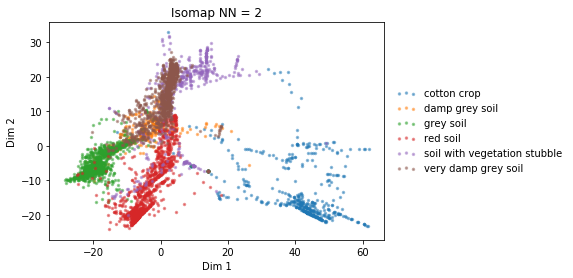

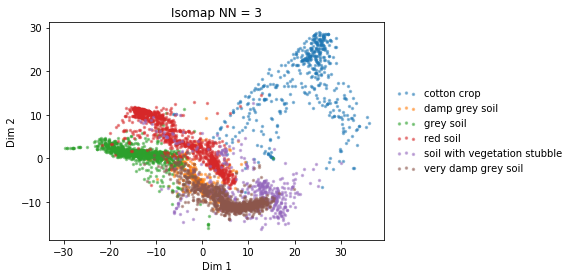

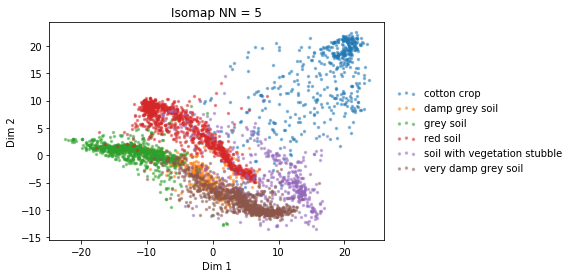

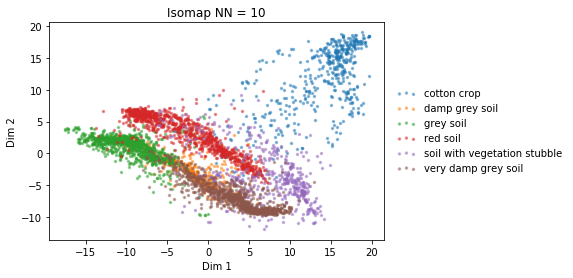

In [168]:
from sklearn.manifold import Isomap

n_neighbors = [2, 3, 5, 10]

for n_neighbor in n_neighbors:
    isomap=Isomap(n_neighbors=n_neighbor, n_components=2)
    isomap_embedding = isomap.fit_transform(X_sc)
    
    fig, ax = plt.subplots()
    scatter_2d_label(isomap_embedding, y, ax=ax)
    ax.set(xlabel='Dim 1', ylabel= 'Dim 2', title='Isomap NN = {}'.format(n_neighbor));

#  Other methods for dimensionality reduction [optional reading]

We here briefly mention two other methods that are widely used and point to code implementing them: 

* Uniform Manifold Approximation and Projection (UMAP)
* t-distributed Stochastic Neighbor (t-SNE) Embedding

UMAP is discussed in the lecture notes. Code that follows the scikit-learn API is available here [here](https://github.com/lmcinnes/umap), and the documentation [here](https://umap-learn.readthedocs.io/en/latest/).

t-SNE is a powerful tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. scikit-learn has an implementation ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)). The following webpage provides an excellent interactive introduction to t-SNE that also allows you to see the impact of its different hyperparameters: http://distill.pub/2016/misread-tsne/